# Aluno

Nome: Rodrigo Edmar Wright Dos Santos
</br> Matrícula: 200027158

# Objetivo

O objetivo deste artigo é criar uma I.A do zero que é capaz de recomendar a melhor plataforma para propaganda de comércio online, com base no público alvo.

# Motivação

Muitas empresas querem ter suas marcas divulgadas, mas não sabem por onde começar. Além disso, ficar administrando um monte de conta em rede social custa dinheiro e tempo, que podem fazer falta para pequenas empresas. Então, uma aplicação capaz de recomendar uma plataforma com base em um publico alvo já conhecido facilitaria na hora da escolha da plataforma ideal.

Para isso, utilizaremos o dataset disponível no Kaggle contendo uma pesquisa feita com jovens da geração Z, que detalha as características desses jovens e a plataforma que mais os influenciam [Social Influence on Shopping](https://www.kaggle.com/datasets/sushilkumarinfo/bitcoin-data-from-9thapr2014-to-30thdec2022?resource=download).

# Configurando o ambiente

Primeiramente devemos instalar as dependencias que serão usadas:

In [1]:
import torch, numpy as np
import pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [2]:
from torch import tensor

In [3]:
from fastai.data.transforms import RandomSplitter

O sympy é uma biblioteca que permite que o python faça algumas equações de álgebra linear.

In [4]:
import sympy

Também é importante definir a pasta onde serão armazenados os dados. Utilizaremos a pasta 'Shopping'.

In [5]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/shopping')
else:
    path = Path('Shopping')

# Limpando os dados

Os dados fornecidos estão no formato CSV (comma separeted values, ou valores separados por vírgula), e podem ser manipulados com a biblioteca previamente instalada Pandas. Ao abrir usando o Pandas será gerado um Data Frame que chamaremos de Table.

In [6]:
table = pd.read_csv(path/'WhatsgoodlyData-6.csv')
table

,index,Question,Segment Type,Segment Description,Answer,Count,Percentage
0,0,What social platform has influenced your online shopping most?,Mobile,Global results,Facebook,548,0.205
1,1,What social platform has influenced your online shopping most?,Mobile,Global results,Instagram,916,0.342
2,2,What social platform has influenced your online shopping most?,Mobile,Global results,Snapchat,86,0.032
3,3,What social platform has influenced your online shopping most?,Mobile,Global results,Twitter,179,0.067
4,4,What social platform has influenced your online shopping most?,Mobile,Global results,None,947,0.354
...,...,...,...,...,...,...,...
1445,1445,What social platform has influenced your online shopping most?,Custom,Sexual orientation? Straight,Facebook,215,0.180
1446,1446,What social platform has influenced your online shopping most?,Custom,Sexual orientation? Straight,Instagram,354,0.297
1447,1447,What social platform has influenced your online shopping most?,Custom,Sexual orientation? Straight,Snapchat,44,0.037
1448,1448,What social platform has influenced your online shopping most?,Custom,Sexual orientation? Straight,Twitter,88,0.074


## Verificação de dados

Para prosseguirmos precisamos saber se existe algum dado inválido, no caso ele estará como NAN (not a number, ou não é um número). Precisamos tratar este tipo de dado agora pois ele não poderá ser manipulado corretamente no futuro e pode gerar problemas.

In [7]:
table.isna().sum()

index                  0
Question               0
Segment Type           0
Segment Description    0
Answer                 0
Count                  0
Percentage             0
dtype: int64

Como podemos perceber acima, não temos valores inválidos no arquivo, portanto podemos prosseguir visualizando os valores numéricos das colunas do dataset.

## Variação de valores

Abaixo temos uma descrição dos valores numéricos de cada coluna do dataset.

In [8]:
table.describe(include=(np.number))

,index,Count,Percentage
count,1450.000000,1450.000000,1450.000000
mean,724.500000,35.013793,0.199313
std,418.723258,95.055604,0.274989
min,0.000000,0.000000,0.000000
25%,362.250000,0.000000,0.000000
50%,724.500000,1.000000,0.063500
75%,1086.750000,20.000000,0.323750
max,1449.000000,947.000000,1.000000


Para ficar mais fácil de visualizar, vamos plotar em um gráfico uma das colunas.

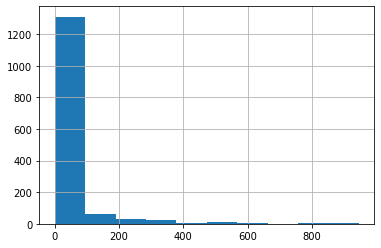

In [9]:
table['Count'].hist();

Como podemos ver, existe uma discrepância entre os valores mínimos e máximos. Essa discrepância no valores dos dados podem afetar o nosso modelo, portanto aplicaremos uma técnica de tirar o logarítimo do número, pois isso fará com que os números muito grandes sejam consideravelmente reduzidos, e os números pequenos se mantenham. No entanto, é importante ressaltar que deve ser somado 1 na equação, pois o logarítmo de 0 é infinito, e isso pode complicar as coisas.

In [10]:
table['logCount'] = np.log(table['Count']+1)

Agora temos uma nova coluna chamada logCount que contém os logarítmos da coluna Count, e sua aparência é assim:

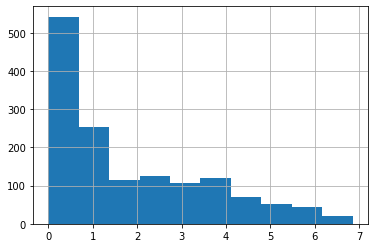

In [11]:
table['logCount'].hist();

Bem melhor! Agora faremos isso para todos os valores com desvio muito grande.

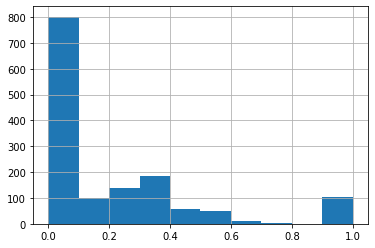

In [12]:
table['Percentage'].hist();

A porcentagem está ok, então não vamos alterá-la.

## Remoção de dados

Para facilitar, e não complicar muito o modelo, iremos remover a coluna Index que não será necessária para este modelo.

In [13]:
table = table.drop(columns=['index'])

In [14]:
table

,Question,Segment Type,Segment Description,Answer,Count,Percentage,logCount
0,What social platform has influenced your online shopping most?,Mobile,Global results,Facebook,548,0.205,6.308098
1,What social platform has influenced your online shopping most?,Mobile,Global results,Instagram,916,0.342,6.821107
2,What social platform has influenced your online shopping most?,Mobile,Global results,Snapchat,86,0.032,4.465908
3,What social platform has influenced your online shopping most?,Mobile,Global results,Twitter,179,0.067,5.192957
4,What social platform has influenced your online shopping most?,Mobile,Global results,None,947,0.354,6.854355
...,...,...,...,...,...,...,...
1445,What social platform has influenced your online shopping most?,Custom,Sexual orientation? Straight,Facebook,215,0.180,5.375278
1446,What social platform has influenced your online shopping most?,Custom,Sexual orientation? Straight,Instagram,354,0.297,5.872118
1447,What social platform has influenced your online shopping most?,Custom,Sexual orientation? Straight,Snapchat,44,0.037,3.806662
1448,What social platform has influenced your online shopping most?,Custom,Sexual orientation? Straight,Twitter,88,0.074,4.488636


## Valores não numéricos

Agora, podemos ver as colunas não numéricas existentes na tabela.

In [15]:
table.describe(include=[object])

,Question,Segment Type,Segment Description,Answer
count,1450,1450,1450,1450
unique,1,5,289,5
top,What social platform has influenced your online shopping most?,University,What's your major? Other,Facebook
freq,1450,870,10,290


A coluna Segment Type, que se refere ao segmento da população que foi pesquisada também não é necessária. Só estamos interessados na descrição e resposta, portanto também podemos remover essas colunas.

In [16]:
table = table.drop(columns=['Question', 'Segment Type', 'Question'])

Agora, temos que transformar todas as descrições e respostas em valores numéricos. Para isso, criaremos colunas para cada valor único. Assim, caso o valor seja válido para aquela tupla, o atributo será 1.

Primeiramente vamos separar o nome das novas colunas em arrays para podermos usar depois.

In [17]:
answer = pd.get_dummies(table, columns = ['Answer'])
answer = list(answer)
answer.remove('Count')
answer.remove('Percentage')
answer.remove('logCount')
answer.remove('Segment Description')
answer

['Answer_Facebook',
 'Answer_Instagram',
 'Answer_None',
 'Answer_Snapchat',
 'Answer_Twitter']

In [18]:
description = pd.get_dummies(table, columns = ['Segment Description'])
description = list(description)
description.remove('Count')
description.remove('Percentage')
description.remove('logCount')
description.remove('Answer')
description

['Segment Description_Appalachian State University',
 'Segment Description_Arbroath Academy',
 'Segment Description_Are you a? SVB team member',
 'Segment Description_Are you a? Student Trekker',
 'Segment Description_Are you single? No',
 'Segment Description_Are you single? Yes',
 'Segment Description_Are you? Christian',
 'Segment Description_Are you? Jewish',
 'Segment Description_Are you? Muslim',
 'Segment Description_Are you? None/Other',
 'Segment Description_Arkansas Tech University ',
 'Segment Description_Auburn University',
 'Segment Description_Azusa Pacific University',
 'Segment Description_Baltimore City College',
 'Segment Description_Bates College',
 'Segment Description_Baylor University',
 'Segment Description_Binghamtom University',
 'Segment Description_Blinn College',
 'Segment Description_Boise State University',
 'Segment Description_Boston University',
 'Segment Description_Brock University',
 'Segment Description_Butler University',
 'Segment Description_Cal 

Destacando as colunas no nosso data frame.

In [19]:
table = pd.get_dummies(table, columns = ['Answer', 'Segment Description'])
table.columns

Index(['Count', 'Percentage', 'logCount', 'Answer_Facebook', 'Answer_Instagram', 'Answer_None', 'Answer_Snapchat', 'Answer_Twitter',
       'Segment Description_Appalachian State University', 'Segment Description_Arbroath Academy',
       ...
       'Segment Description_your zodiac sign? Cancer (Jun 21 - Jul 22)',
       'Segment Description_your zodiac sign? Capricorn (Dec 22 - Jan 19)',
       'Segment Description_your zodiac sign? Gemini (May 21 - Jun 20)', 'Segment Description_your zodiac sign? Leo (Jul 23 - Aug 22)',
       'Segment Description_your zodiac sign? Libra (Sep 23 - Oct 22)', 'Segment Description_your zodiac sign? Pisces (Feb 19 - Mar 20)',
       'Segment Description_your zodiac sign? Sagittarius (Nov 22 - Dec 21)',
       'Segment Description_your zodiac sign? Scorpio (Oct 23 - Nov 21)', 'Segment Description_your zodiac sign? Taurus (Apr 20 - May 20)',
       'Segment Description_your zodiac sign? Virgo (Aug 23 - Sep 22)'],
      dtype='object', length=297)

Agora nossa tabela tem um monte de coluna... Mas tudo bem.

In [20]:
Added_cols = answer + description
table[Added_cols].head()

,Answer_Facebook,Answer_Instagram,Answer_None,Answer_Snapchat,Answer_Twitter,Segment Description_Appalachian State University,Segment Description_Arbroath Academy,Segment Description_Are you a? SVB team member,Segment Description_Are you a? Student Trekker,Segment Description_Are you single? No,...,Segment Description_your zodiac sign? Cancer (Jun 21 - Jul 22),Segment Description_your zodiac sign? Capricorn (Dec 22 - Jan 19),Segment Description_your zodiac sign? Gemini (May 21 - Jun 20),Segment Description_your zodiac sign? Leo (Jul 23 - Aug 22),Segment Description_your zodiac sign? Libra (Sep 23 - Oct 22),Segment Description_your zodiac sign? Pisces (Feb 19 - Mar 20),Segment Description_your zodiac sign? Sagittarius (Nov 22 - Dec 21),Segment Description_your zodiac sign? Scorpio (Oct 23 - Nov 21),Segment Description_your zodiac sign? Taurus (Apr 20 - May 20),Segment Description_your zodiac sign? Virgo (Aug 23 - Sep 22)
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Configuração de modelo

Depois de ter ajustado os dados, precisamos configurar o nosso modelo. Primeiramente devemos definir os valores independentes (valores que serão fornecidos para a previsão) e os valores dependentes (valores a serem previstos).

Nossas variáveis dependentes são as respostas dos usuários.

In [21]:
t_dep = tensor(table[answer].values, dtype=torch.float)
t_dep

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.]])

In [22]:
t_dep.shape

torch.Size([1450, 5])

A variável independente é todo o resto.

In [23]:
indep_cols = description + ['Percentage', 'logCount']
t_indep = tensor(table[indep_cols].values, dtype=torch.float)
t_indep

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2050, 6.3081],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3420, 6.8211],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0320, 4.4659],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0670, 5.1930],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3540, 6.8544],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.00

In [24]:
t_indep.shape

torch.Size([1450, 291])

In [25]:
len(t_indep.shape)

2

O rank dos nossos dados é dois, sendo assim é uma tabela.

Portanto temos 1450 fileiras e 291 colunas de dados para fazer as previsões.

## Ajustando coeficientes

Para definir o coeficiente vamos deixar o computador pegar números aleatórios com base em uma seed prédefinida.

In [26]:
torch.manual_seed(400)

n_coeff = t_indep.shape[1]
coeffs1 = torch.rand(n_coeff)-0.5
coeffs1

tensor([-0.3054,  0.1604,  0.3556, -0.3488,  0.4805,  0.0355, -0.1592,  0.2165,  0.4433, -0.0998, -0.4156,  0.0047,  0.1954,  0.0249,
         0.1124, -0.2972, -0.3741, -0.1233,  0.4291,  0.2529, -0.0195, -0.4241, -0.3065, -0.2175, -0.4453,  0.0209, -0.3894, -0.1426,
         0.0794,  0.3319, -0.4313,  0.2052,  0.2464, -0.1597, -0.1903,  0.2712,  0.3399, -0.4344, -0.3047,  0.0973,  0.3700,  0.2370,
        -0.0623, -0.2708, -0.1901, -0.2360, -0.2607, -0.1334, -0.4843, -0.3091, -0.2881,  0.4584,  0.0008, -0.0446, -0.2921,  0.4965,
        -0.1517,  0.4532,  0.2540, -0.2390,  0.4610,  0.3875, -0.1047, -0.0317, -0.2036, -0.1798,  0.1206,  0.4405, -0.3510,  0.3172,
        -0.1856, -0.1710,  0.1663, -0.4941,  0.3970, -0.1754, -0.0189, -0.3871, -0.0785, -0.4223,  0.3580,  0.0798,  0.0785,  0.1573,
        -0.2822, -0.4445, -0.4827,  0.2927,  0.2926, -0.0552, -0.1400, -0.2547, -0.4538, -0.0540, -0.1375, -0.3568, -0.1068,  0.3163,
        -0.2231,  0.3110, -0.4074, -0.4687, -0.2904,  0.1947, 

O modelo irá pegar esses coeficientes aleatórios gerados, e multiplicá-los pelos valores da matriz independente:

In [27]:
t_indep*coeffs1

tensor([[-0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0742,
         -2.7000],
        [-0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.1237,
         -2.9196],
        [-0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0116,
         -1.9115],
        [-0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0242,
         -2.2227],
        [-0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.1281,
         -2.9338],
        [-0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,
         -0.0000],
        [-0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000

A soma de cada fileira é uma previsão. Precisamos de 5 previsões para cada resposta, então vamos criar mais 4 coeficientes diferentes.

In [28]:
torch.manual_seed(401)
coeffs2 = torch.rand(n_coeff)-0.5

torch.manual_seed(402)
coeffs3 = torch.rand(n_coeff)-0.5

torch.manual_seed(403)
coeffs4 = torch.rand(n_coeff)-0.5

torch.manual_seed(404)
coeffs5 = torch.rand(n_coeff)-0.5

Vamos fazer uma lista com a previsão de cada coeficiente.

In [29]:
predsList = [(t_indep*coeffs1).sum(axis=1), (t_indep*coeffs2).sum(axis=1), (t_indep*coeffs3).sum(axis=1), (t_indep*coeffs4).sum(axis=1), (t_indep*coeffs5).sum(axis=1)]
predsList

[tensor([-2.9139, -3.0839, -2.1880, -2.4865, -3.0938,  0.4444,  0.4444,  ..., -1.8686, -2.4954, -1.8264, -1.9967, -1.2067, -1.4853,
         -2.0957]),
 tensor([-2.6452, -2.9372, -1.7070, -2.0657, -2.9572,  0.1475,  0.1475,  ..., -2.5985, -3.5214, -3.0185, -3.2959, -2.2212, -2.5591,
         -3.4924]),
 tensor([2.6561, 2.9370, 1.7739, 2.1088, 2.9565, 0.4370, 0.4370,  ..., 1.8603, 2.7381, 2.8718, 3.1376, 2.1223, 2.4382, 3.3283]),
 tensor([ 2.5411,  2.8120,  1.7037,  2.0201,  2.8309, -0.1060, -0.1060,  ...,  1.9525,  2.7923,  2.1249,  2.3806,  1.4137,  1.7122,
          2.5657]),
 tensor([-2.2246, -2.4734, -1.4594, -1.7480, -2.4908, -0.2539, -0.2539,  ..., -1.9184, -2.6877, -1.6220, -1.8567, -0.9722, -1.2446,
         -2.0269])]

Para a lista ficar em um formato desejado, vamos juntar todos os tensors e transpor a matriz.

In [30]:
preds = torch.stack(predsList)
preds = np.transpose(preds)
preds

tensor([[-2.9139, -2.6452,  2.6561,  2.5411, -2.2246],
        [-3.0839, -2.9372,  2.9370,  2.8120, -2.4734],
        [-2.1880, -1.7070,  1.7739,  1.7037, -1.4594],
        [-2.4865, -2.0657,  2.1088,  2.0201, -1.7480],
        [-3.0938, -2.9572,  2.9565,  2.8309, -2.4908],
        [ 0.4444,  0.1475,  0.4370, -0.1060, -0.2539],
        [ 0.4444,  0.1475,  0.4370, -0.1060, -0.2539],
        ...,
        [-1.8686, -2.5985,  1.8603,  1.9525, -1.9184],
        [-2.4954, -3.5214,  2.7381,  2.7923, -2.6877],
        [-1.8264, -3.0185,  2.8718,  2.1249, -1.6220],
        [-1.9967, -3.2959,  3.1376,  2.3806, -1.8567],
        [-1.2067, -2.2212,  2.1223,  1.4137, -0.9722],
        [-1.4853, -2.5591,  2.4382,  1.7122, -1.2446],
        [-2.0957, -3.4924,  3.3283,  2.5657, -2.0269]])

Agora que temos as previsões na forma correta, também podemos calcular o loss da iteração:

In [31]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.9696)

Agora que podemos fazer previsões, podemos inserir esse código em uma função para continuar.

Função que calcula as previsões:

In [32]:
def calc_preds(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, indeps):
    preds = [(indeps*coeffs1).sum(axis=1), (indeps*coeffs2).sum(axis=1), (indeps*coeffs3).sum(axis=1), (indeps*coeffs4).sum(axis=1), (indeps*coeffs5).sum(axis=1)]
    preds = torch.stack(preds)
    preds = preds.transpose(0, 1)
    return preds #.requires_grad_()

Função que calcula o loss:

In [33]:
def calc_loss(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, indeps, deps): 
    return torch.abs(calc_preds(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, indeps)-deps).mean()

## Gradiente de coeficiente

Podemos alterar o coeficiente seguindo os passos abaixo. Iremos automatizar a definição de gradientes, sendo assim, vamos fazet todos os coeficientes terem "requires_grad=true".

In [34]:
coeffs1.requires_grad_()

tensor([-0.3054,  0.1604,  0.3556, -0.3488,  0.4805,  0.0355, -0.1592,  0.2165,  0.4433, -0.0998, -0.4156,  0.0047,  0.1954,  0.0249,
         0.1124, -0.2972, -0.3741, -0.1233,  0.4291,  0.2529, -0.0195, -0.4241, -0.3065, -0.2175, -0.4453,  0.0209, -0.3894, -0.1426,
         0.0794,  0.3319, -0.4313,  0.2052,  0.2464, -0.1597, -0.1903,  0.2712,  0.3399, -0.4344, -0.3047,  0.0973,  0.3700,  0.2370,
        -0.0623, -0.2708, -0.1901, -0.2360, -0.2607, -0.1334, -0.4843, -0.3091, -0.2881,  0.4584,  0.0008, -0.0446, -0.2921,  0.4965,
        -0.1517,  0.4532,  0.2540, -0.2390,  0.4610,  0.3875, -0.1047, -0.0317, -0.2036, -0.1798,  0.1206,  0.4405, -0.3510,  0.3172,
        -0.1856, -0.1710,  0.1663, -0.4941,  0.3970, -0.1754, -0.0189, -0.3871, -0.0785, -0.4223,  0.3580,  0.0798,  0.0785,  0.1573,
        -0.2822, -0.4445, -0.4827,  0.2927,  0.2926, -0.0552, -0.1400, -0.2547, -0.4538, -0.0540, -0.1375, -0.3568, -0.1068,  0.3163,
        -0.2231,  0.3110, -0.4074, -0.4687, -0.2904,  0.1947, 

In [35]:
coeffs2.requires_grad_()


tensor([     0.1758,      0.0850,      0.1254,     -0.3928,     -0.4761,     -0.0292,      0.4927,     -0.1974,     -0.0614,      0.2615,
            -0.2286,     -0.3858,      0.0050,     -0.4888,      0.0685,      0.2973,      0.0775,     -0.1543,      0.3942,      0.0961,
            -0.3301,     -0.4896,      0.1776,     -0.4219,      0.4496,     -0.1411,      0.0068,      0.0261,      0.0987,      0.2087,
             0.3249,     -0.0650,     -0.1459,      0.3127,     -0.0620,      0.4663,      0.1273,     -0.1490,     -0.0177,     -0.1471,
            -0.4360,     -0.0137,      0.4569,      0.0453,     -0.1749,      0.4278,     -0.0897,      0.2420,      0.4373,      0.2089,
             0.4329,      0.1928,     -0.4320,      0.0437,      0.3065,      0.2478,      0.1099,      0.2539,      0.1461,      0.2591,
            -0.4138,     -0.1762,     -0.1606,      0.2570,     -0.4100,     -0.2671,     -0.3790,      0.4857,      0.2594,      0.1746,
             0.1965,      0.1272, 

In [36]:
coeffs3.requires_grad_()

tensor([-0.4804, -0.3790, -0.4646, -0.0590,  0.2804,  0.4991,  0.3185, -0.2232,  0.2268, -0.0395,  0.0481,  0.4806, -0.0678, -0.3413,
         0.4215, -0.2137, -0.1631,  0.0101,  0.2008,  0.3917,  0.0900,  0.1177,  0.1723, -0.2921,  0.4121,  0.3468,  0.2358,  0.3110,
         0.0879, -0.0064,  0.1420, -0.0605,  0.4383,  0.4829,  0.0990,  0.3818,  0.1176, -0.0911,  0.2491,  0.1707,  0.3048,  0.3006,
         0.0580, -0.3571, -0.0728, -0.3363,  0.3442,  0.2710,  0.4306,  0.2706, -0.2108,  0.2253,  0.3242,  0.0770,  0.0345, -0.1355,
         0.1370,  0.1540, -0.4880, -0.4175, -0.2949, -0.1666, -0.1010, -0.3919,  0.2805, -0.2801,  0.2053,  0.0718, -0.1677,  0.2202,
        -0.4735,  0.2370, -0.0601,  0.4935, -0.0207,  0.3467,  0.3058, -0.4515,  0.2406, -0.0413,  0.1102, -0.2379,  0.3335,  0.1319,
        -0.1077, -0.3936,  0.1009, -0.1637, -0.0678, -0.1265, -0.2092,  0.2757, -0.3008,  0.3801,  0.2074,  0.3845,  0.0423, -0.2666,
        -0.0052, -0.3772,  0.0844,  0.2715, -0.1767, -0.2552, 

In [37]:
coeffs4.requires_grad_()

tensor([     0.1876,      0.3691,      0.3619,      0.0961,     -0.2184,      0.1237,     -0.3835,     -0.4225,     -0.0505,      0.1939,
             0.1293,     -0.1195,      0.0626,     -0.2583,     -0.1240,     -0.2645,      0.4715,      0.3814,     -0.0865,     -0.1336,
            -0.4875,      0.4844,      0.2919,      0.1672,      0.4693,     -0.3845,     -0.1440,      0.4813,     -0.4664,     -0.2652,
            -0.1799,     -0.2130,     -0.4370,     -0.4332,      0.2787,     -0.4625,     -0.1872,      0.1588,      0.3494,     -0.2555,
            -0.0454,     -0.0006,     -0.1706,     -0.2744,      0.0246,     -0.1880,      0.0368,      0.1107,      0.1972,     -0.0048,
            -0.1618,     -0.4198,      0.0148,     -0.3302,     -0.3492,     -0.2725,     -0.0367,     -0.4429,     -0.4967,     -0.3795,
            -0.1670,      0.2337,      0.2123,     -0.1898,      0.4500,     -0.3318,     -0.2271,      0.2335,      0.2556,     -0.0946,
            -0.1250,     -0.4447, 

In [38]:
coeffs5.requires_grad_()

tensor([-0.2808, -0.2575,  0.2821,  0.3001,  0.1351,  0.0375, -0.3230,  0.0438, -0.0633,  0.2706,  0.4802, -0.4841,  0.3735,  0.2938,
         0.0993,  0.2170,  0.4296,  0.0368, -0.1716, -0.0015, -0.3919, -0.1763,  0.2585,  0.3446,  0.3879,  0.3255, -0.3150, -0.1051,
         0.0331, -0.4546,  0.3304,  0.2196, -0.0792,  0.4604, -0.4041, -0.1335, -0.0277,  0.4823,  0.2875, -0.0082, -0.3252,  0.4322,
        -0.4261, -0.3181, -0.4741,  0.3276,  0.2825, -0.1273,  0.2542, -0.2473,  0.2397,  0.2196, -0.0052,  0.2996,  0.4909,  0.2635,
         0.1979,  0.2708,  0.2920,  0.3407,  0.3307, -0.1726,  0.0143, -0.0518,  0.0667, -0.4926,  0.2040, -0.3865, -0.3116,  0.4310,
         0.3754,  0.1615, -0.0828,  0.4078,  0.2770, -0.2328, -0.1238,  0.4532, -0.3022,  0.0116, -0.0099,  0.1936, -0.0747, -0.0170,
        -0.2862, -0.4280, -0.4661, -0.2745,  0.3249, -0.1044,  0.3852, -0.0870, -0.1785, -0.4916, -0.4143, -0.4466, -0.0528,  0.0119,
        -0.3889,  0.3595, -0.1112, -0.1626,  0.0830, -0.1360, 

Agora, como podemos ver a máquina consegue calcular de volta todos os passos que foram dados.

In [39]:
loss = calc_loss(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, t_indep, t_dep)
loss

tensor(0.9696, grad_fn=<MeanBackward0>)

A função backward vai calcular os gradientes de todos os coeficientes.

In [40]:
loss.backward()

In [41]:
coeffs1.grad

tensor([    -0.0007,      0.0004,      0.0004,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0004,     -0.0007,
            -0.0007,      0.0001,      0.0004,      0.0004,     -0.0004,     -0.0007,     -0.0007,     -0.0007,      0.0004,      0.0004,
            -0.0004,     -0.0007,     -0.0007,     -0.0007,     -0.0007,      0.0001,     -0.0007,     -0.0007,      0.0004,     -0.0001,
            -0.0007,      0.0004,      0.0004,     -0.0007,     -0.0007,      0.0004,      0.0004,     -0.0007,     -0.0007,      0.0004,
             0.0001,      0.0004,     -0.0004,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,
            -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,      0.0004,     -0.0007,      0.0004,      0.0004,     -0.0007,
            -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,      0.0004,      0.0004,     -0.0007,      0.0004,
            -0.0007,     -0.0007, 

In [42]:
coeffs2.grad

tensor([    -0.0004,      0.0001,      0.0004,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,
            -0.0007,     -0.0007,      0.0004,     -0.0007,     -0.0004,      0.0001,      0.0001,     -0.0007,      0.0004,      0.0004,
            -0.0007,     -0.0007,      0.0001,     -0.0007,      0.0001,     -0.0007,      0.0004,      0.0001,      0.0004,     -0.0001,
            -0.0007,     -0.0007,     -0.0007,      0.0001,     -0.0007,     -0.0001,      0.0001,     -0.0007,     -0.0007,     -0.0007,
            -0.0007,     -0.0007,      0.0001,      0.0001,     -0.0007,      0.0004,     -0.0007,      0.0004,      0.0004,      0.0004,
            -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,      0.0001,      0.0001,      0.0001,      0.0001,     -0.0007,
            -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,      0.0004,      0.0001,      0.0001,
            -0.0004,      0.0004, 

In [43]:
coeffs3.grad

tensor([     0.0001,     -0.0004,     -0.0007,     -0.0004,      0.0007,      0.0007,      0.0007,      0.0007,      0.0007,      0.0007,
             0.0004,      0.0007,     -0.0004,     -0.0007,      0.0007,     -0.0007,     -0.0007,      0.0004,      0.0004,      0.0004,
             0.0004,      0.0007,      0.0007,     -0.0004,      0.0007,      0.0007,      0.0004,      0.0007,      0.0004,     -0.0001,
             0.0007,     -0.0004,      0.0004,      0.0007,      0.0007,      0.0004,      0.0004,      0.0007,      0.0004,      0.0004,
             0.0007,      0.0004,      0.0004,     -0.0004,      0.0007,     -0.0004,      0.0007,      0.0004,      0.0004,      0.0004,
             0.0007,      0.0007,      0.0007,      0.0007,      0.0007,     -0.0007,      0.0004,      0.0007,     -0.0007,      0.0007,
             0.0007,      0.0007,      0.0004,      0.0001,      0.0007,      0.0007,      0.0004,      0.0004,     -0.0004,      0.0004,
            -0.0004,      0.0004, 

In [44]:
coeffs4.grad

tensor([     0.0004,      0.0004,      0.0004,      0.0004,      0.0004,      0.0007,      0.0007,      0.0004,      0.0004,      0.0007,
             0.0004,     -0.0004,      0.0004,     -0.0004,      0.0004,     -0.0004,      0.0004,      0.0004,     -0.0004,     -0.0004,
            -0.0004,      0.0004,      0.0004,      0.0004,      0.0004,     -0.0001,     -0.0004,      0.0004,     -0.0004,      0.0001,
             0.0004,     -0.0004,     -0.0004,     -0.0004,      0.0007,     -0.0001,     -0.0004,      0.0004,      0.0004,     -0.0004,
             0.0004,     -0.0001,     -0.0004,     -0.0004,      0.0004,     -0.0004,      0.0007,      0.0004,      0.0004,     -0.0004,
             0.0007,      0.0004,      0.0007,      0.0007,      0.0004,     -0.0004,     -0.0007,     -0.0004,     -0.0004,      0.0007,
             0.0004,      0.0007,      0.0004,      0.0004,      0.0004,      0.0004,     -0.0001,      0.0004,      0.0004,     -0.0004,
             0.0004,     -0.0004, 

In [45]:
coeffs5.grad

tensor([    -0.0007,     -0.0007,      0.0004,      0.0001,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,
             0.0001,     -0.0007,      0.0001,      0.0001,     -0.0004,      0.0001,      0.0001,      0.0001,     -0.0007,     -0.0007,
            -0.0007,     -0.0007,      0.0001,      0.0001,      0.0001,     -0.0001,     -0.0007,     -0.0007,      0.0001,     -0.0007,
            -0.0004,      0.0001,     -0.0007,      0.0001,     -0.0007,     -0.0007,     -0.0007,     -0.0007,      0.0001,     -0.0007,
            -0.0007,      0.0001,     -0.0007,     -0.0007,     -0.0007,      0.0001,     -0.0007,     -0.0007,      0.0001,     -0.0007,
            -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,      0.0001,      0.0001,      0.0001,      0.0001,     -0.0007,
            -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0007,     -0.0001,     -0.0007,     -0.0007,      0.0001,
            -0.0001,      0.0001, 

Agora toda vez que fizermos o processo novamente, os coeficientes serão levemente alterados.

In [46]:
loss = calc_loss(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, t_indep, t_dep)
loss.backward()
coeffs1.grad

tensor([    -0.0014,      0.0008,      0.0008,     -0.0014,     -0.0014,     -0.0014,     -0.0014,     -0.0014,     -0.0008,     -0.0014,
            -0.0014,      0.0003,      0.0008,      0.0008,     -0.0008,     -0.0014,     -0.0014,     -0.0014,      0.0008,      0.0008,
            -0.0008,     -0.0014,     -0.0014,     -0.0014,     -0.0014,      0.0003,     -0.0014,     -0.0014,      0.0008,     -0.0003,
            -0.0014,      0.0008,      0.0008,     -0.0014,     -0.0014,      0.0008,      0.0008,     -0.0014,     -0.0014,      0.0008,
             0.0003,      0.0008,     -0.0008,     -0.0014,     -0.0014,     -0.0014,     -0.0014,     -0.0014,     -0.0014,     -0.0014,
            -0.0014,     -0.0014,     -0.0014,     -0.0014,     -0.0014,      0.0008,     -0.0014,      0.0008,      0.0008,     -0.0014,
            -0.0014,     -0.0014,     -0.0014,     -0.0014,     -0.0014,     -0.0014,      0.0008,      0.0008,     -0.0014,      0.0008,
            -0.0014,     -0.0014, 

Agora, o loss cai toda vez que rodamos esses códigos.

In [47]:
loss = calc_loss(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs1.sub_(coeffs1.grad * 0.1)
    coeffs1.grad.zero_()
    coeffs2.sub_(coeffs2.grad * 0.1)
    coeffs2.grad.zero_()
    coeffs3.sub_(coeffs3.grad * 0.1)
    coeffs3.grad.zero_()
    coeffs4.sub_(coeffs4.grad * 0.1)
    coeffs4.grad.zero_()
    coeffs5.sub_(coeffs5.grad * 0.1)
    coeffs5.grad.zero_()
    print(calc_loss(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, t_indep, t_dep))

tensor(0.8158)


Como podemos ver o loss caiu levemente, se comparado com a primeira interação. Muito bom!

# Treinando o modelo linear

Antes de começar o treinamento, devemos dividir os dados para treinamento e validação. Para isso, utilizaremos o random spliter, para separar os dados de forma aleatória.

In [48]:
train,validation = RandomSplitter(seed=8)(table)

Podemos definir cada divisão agora:

In [49]:
trn_indep,val_indep = t_indep[train],t_indep[validation]
trn_dep,val_dep = t_dep[train],t_dep[validation]
len(trn_indep),len(val_indep)

(1160, 290)

Vamos criar funções para os gradientes que nós fizemos manualmente

In [50]:
def update_coeffs(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, constant):
    coeffs1.sub_(coeffs1.grad * constant)
    coeffs1.grad.zero_()
    coeffs2.sub_(coeffs2.grad * constant)
    coeffs2.grad.zero_()
    coeffs3.sub_(coeffs3.grad * constant)
    coeffs3.grad.zero_()
    coeffs4.sub_(coeffs4.grad * constant)
    coeffs4.grad.zero_()
    coeffs5.sub_(coeffs5.grad * constant)
    coeffs5.grad.zero_()

Função para um ciclo:

In [51]:
def one_epoch(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, constant):
    loss = calc_loss(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, constant)
    print(f"{loss:.3f}", end="; ")

In [52]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

Com essas funções é possível criar uma nova função que treina o modelo.

In [53]:
def train_model(epochs=30, constant=0.01):
    torch.manual_seed(440)
    coeffs1 = init_coeffs()
    torch.manual_seed(441)
    coeffs2 = init_coeffs()
    torch.manual_seed(442)
    coeffs3 = init_coeffs()
    torch.manual_seed(443)
    coeffs4 = init_coeffs()
    torch.manual_seed(444)
    coeffs5 = init_coeffs()
    for i in range(epochs): one_epoch(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, constant=constant)
    return [coeffs1, coeffs2, coeffs3, coeffs4, coeffs5]

Agora podemos testar o modelo, o esperado é que o loss gerado pela função diminua a cada época.

In [54]:
coeffs = train_model(18, constant=0.2)

0.632; 0.571; 0.517; 0.472; 0.438; 0.414; 0.403; 0.399; 0.397; 0.396; 0.396; 0.396; 0.396; 0.396; 0.395; 0.395; 0.395; 0.395; 

Está caindo, isso é um bom sinal.

Podemos ver os coeficientes em cada coluna, vamos ver a do coeficiente 1:

In [55]:
def show_coeffs(coeffs0): return dict(zip(indep_cols, coeffs0.requires_grad_(False)))
show_coeffs(coeffs[0])

{'Segment Description_Appalachian State University': tensor(0.4954),
 'Segment Description_Arbroath Academy': tensor(-0.1573),
 'Segment Description_Are you a? SVB team member': tensor(-0.4202),
 'Segment Description_Are you a? Student Trekker': tensor(0.3204),
 'Segment Description_Are you single? No': tensor(0.4190),
 'Segment Description_Are you single? Yes': tensor(0.3964),
 'Segment Description_Are you? Christian': tensor(0.3864),
 'Segment Description_Are you? Jewish': tensor(0.0186),
 'Segment Description_Are you? Muslim': tensor(0.2333),
 'Segment Description_Are you? None/Other': tensor(0.2903),
 'Segment Description_Arkansas Tech University ': tensor(-0.4635),
 'Segment Description_Auburn University': tensor(-0.0330),
 'Segment Description_Azusa Pacific University': tensor(-0.3654),
 'Segment Description_Baltimore City College': tensor(0.4389),
 'Segment Description_Bates College': tensor(0.3024),
 'Segment Description_Baylor University': tensor(-0.1370),
 'Segment Descriptio

# Medindo a Acurácia

Para medir a acurácia, primeiramente precisamos definir os valores que fazem com que uma opção é válida ou não.

In [56]:
preds = calc_preds(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, val_indep)

Vamos supor que se a predição for maior que 0,5 então a plataforma é recomenda

In [57]:
val_dep

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.]])

In [58]:
results = (val_dep.bool()==(preds>0.5))
results[:12]

tensor([[ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [ True, False, False, False,  True],
        [False,  True,  True,  True,  True],
        [ True,  True, False, False, False],
        [ True, False,  True,  True,  True],
        [ True,  True,  True, False,  True],
        [ True, False, False, False,  True],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]])

Podemos agora calcular o valor médio da acurácia.

In [59]:
results.float().mean()

tensor(0.6793)

Um bom valor para começar! Podemos fazer uma função que calcula o valor médio para os modelos que nós treinamos.

In [60]:
def acc(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5): 
    return (val_dep.bool()==(calc_preds(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, val_indep)>0.5)).float().mean()
acc(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5)

tensor(0.6793)

# Sigmoid

É possível notar que o valor das predições não está dentro do intervalo de 0 a 1. Isso dificulta a visualização e a tirar conclusões. Portanto vamos concertar utilizando a função sigmoid, que faz com que os valores fiquem com um máximo de 1 e um mínimo de 0.

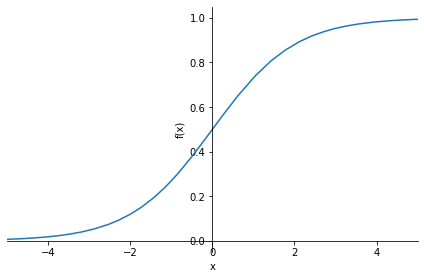

In [61]:
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

Vamos fazer com que a nossa função previamente criada já saia no formato sigmoid.

In [62]:
def calc_preds(coeffs1, coeffs2, coeffs3, coeffs4, coeffs5, indeps):
    preds = [(indeps*coeffs1).sum(axis=1), (indeps*coeffs2).sum(axis=1), (indeps*coeffs3).sum(axis=1), (indeps*coeffs4).sum(axis=1), (indeps*coeffs5).sum(axis=1)]
    preds = torch.stack(preds)
    preds = preds.transpose(0, 1)
    return torch.sigmoid(preds)

## Treinando novo modelo

Vamos treinar um novo modelo para ver como ele vai desempenhar.

In [63]:
coeffs = train_model(100, constant=100)

0.527; 0.322; 0.320; 0.319; 0.318; 0.317; 0.316; 0.315; 0.315; 0.314; 0.313; 0.312; 0.312; 0.311; 0.310; 0.310; 0.309; 0.308; 0.308; 0.307; 0.306; 0.306; 0.305; 0.304; 0.304; 0.303; 0.303; 0.302; 0.301; 0.301; 0.300; 0.300; 0.299; 0.299; 0.298; 0.297; 0.297; 0.296; 0.296; 0.295; 0.295; 0.294; 0.293; 0.293; 0.292; 0.292; 0.291; 0.291; 0.290; 0.290; 0.289; 0.289; 0.288; 0.288; 0.287; 0.287; 0.286; 0.286; 0.285; 0.285; 0.284; 0.284; 0.283; 0.283; 0.282; 0.282; 0.281; 0.281; 0.280; 0.280; 0.279; 0.279; 0.279; 0.278; 0.278; 0.277; 0.277; 0.276; 0.276; 0.275; 0.275; 0.275; 0.274; 0.274; 0.273; 0.273; 0.273; 0.272; 0.272; 0.271; 0.271; 0.271; 0.270; 0.270; 0.269; 0.269; 0.269; 0.268; 0.268; 0.268; 

In [64]:
acc(coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4])

tensor(0.7593)

Ok, nota-se que houve uma melhora na acurácia do modelo desde então.

# Testando

Vamos testar a rede com dados retirados de uma planilha que criamos.

In [65]:
path2 = Path('../input/shoppingtest')
test_table = pd.read_csv(path2/'teste.csv')

Aqui está nossa tabela de teste.

Temos 2 casos, o primeiro para um público de 60 homens, não solteiros formados em economia e o segundo para um público de 40 mulheres, solteiras de escola privada.

In [66]:
test_table

,count,porcentage,Global results,Web,Female voters,Male voters,University of Delaware,University of Pennsylvania,Students of New York,University of Central Arkansas,...,What's your leaning? In-between,Are you? Muslim,Are you? Christian,Graduation Year 2017,Graduation Year 2018,What's your GPA? Above 4.0 😏,Graduation Year 2019,Graduation Year 2020,closely identify as? White,Sexual orientation? Straight
0,60,0.6,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,40,0.4,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Os valores que não foram fornecidos estão como NaN, vamos concertar isso colocando um 0 em todos os NaN.

In [67]:
test_table = test_table.fillna(0)
test_table

,count,porcentage,Global results,Web,Female voters,Male voters,University of Delaware,University of Pennsylvania,Students of New York,University of Central Arkansas,...,What's your leaning? In-between,Are you? Muslim,Are you? Christian,Graduation Year 2017,Graduation Year 2018,What's your GPA? Above 4.0 😏,Graduation Year 2019,Graduation Year 2020,closely identify as? White,Sexual orientation? Straight
0,60,0.6,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40,0.4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Podemos calcular as previsões agora:

In [68]:
test_indep = tensor(test_table.values, dtype=torch.float)

In [69]:
calc_preds(coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], test_indep)


tensor([[    1.0000,     0.9835,     0.0000,     0.0086,     1.0000],
        [    1.0000,     0.9444,     0.0000,     0.0219,     1.0000]], grad_fn=<SigmoidBackward0>)

A ordem das colunas é 'Answer_Facebook', 'Answer_Instagram', 'Answer_None', 'Answer_Snapchat', 'Answer_Twitter' assim como visto no início.

Então concluimos que para esse caso de teste a rede recomendou Facebook e Instagram com tachas bem altas. Ela também recomendou o none, que foi usado para pesquisa caso os participantes não sejam influenciados por nenhuma mídia.